In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp core

# fastai-breadcrumbs.core

> Functions for fastaibreadcrumbs.

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from fastai.vision.all import *
from fastkaggle import *

## Setting kaggle data on local machine

In [ ]:
#|export
def setup_data(user: str, dataset: str, install=''):
    "Get a path to data for the `user's` `dataset`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/dataset
    else:
        path = Path(dataset)
        from kaggle import api
        if not path.exists():
            api.dataset_download_cli(f'{user}/{dataset}', path=str(path), unzip=True)
        return path

This function is similar to the `setup_comp` function in ["fastkaggle"](https://fastai.github.io/fastkaggle/) which will download the dataset from kaggle and unzip it to your local machine if it's not there already. Be sure to have setup a kaggle API for your username and have the kaggle.json downloaded to youtr local machine before using this function.

For example when you do the following-->

```
setup_data('sapal6', 'superresolution')
```

The output would be 

```
Path('superresolution/busystreet')
```

## Crappify your data

In [ ]:
#|export
class Crappifier:
    """class to crappify images"""
    def __init__(self, path_hr, path_crappy):
        self.cvmodule = __import__('cv2')
        self.path_hr = path_hr
        self.path_crappy = path_crappy

    def __apply_motion_blur(self, img: Path, sz: int, angle: int):
        """apply motion blur in images at the givn angle and size of blur lines"""
        k = np.zeros((sz, sz), dtype=np.float32)
        k[ (sz-1)// 2 , :] = np.ones(sz, dtype=np.float32)
        k = self.cvmodule.warpAffine(k, self.cvmodule.getRotationMatrix2D( (sz / 2 -0.5 , sz / 2 -0.5 ) , angle, 1.0), (sz, sz) )  
        k = k * ( 1.0 / np.sum(k) )        
        return self.cvmodule.filter2D(img, -1, k) 

    def __call__(self, fn: Path):
        """apply motion blur on images"""
        dest = self.path_crappy/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = self.cvmodule.imread(str(fn))
        img = self.__apply_motion_blur(img, 30, 0)
        self.cvmodule.imwrite(str(dest), img)

In [ ]:
show_doc(Crappifier.__call__)

---

#### Crappifier.__call__

>      Crappifier.__call__ (fn:pathlib.Path)

apply motion blur on images

In [ ]:
file_hr = 'test/imgs/test_img.jpg'

In [ ]:
crappifier = Crappifier(Path('test/imgs'), Path('test/crappy'))
crappifier(Path(file_hr))

In [ ]:
def show_plot(fns: L, nrow:int, szs: tuple):
    """show the original image and the crappified image side by side for given bumber of rows and figure size"""
    _, axs = plt.subplots(nrow, 2, figsize=szs)
    axs[0].set_title("original")
    axs[1].set_title("crappy")
    axs = axs.flatten()
    for fn, ax in zip(fns, axs):
        img = Image.open(fn)
        ax.imshow(img)

In [ ]:
file_crappy = 'test/crappy/test_img.jpg'

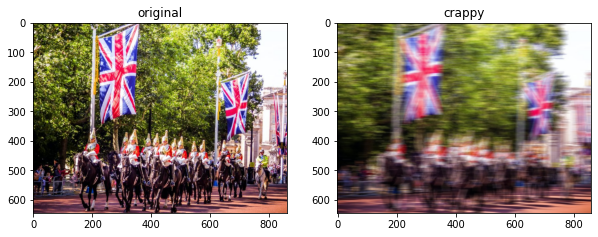

In [ ]:
show_plot([Path(file_hr), file_crappy], 1, [10, 10])

## Quickly create dataloader for Unet

In [ ]:
#|export
def get_unet_dls(bs:int,  source=None,
                  blocks: tuple=(ImageBlock, ImageBlock), dl_type=None, getters=None,
                  n_inp=None, get_items=None, get_y=None, get_x=None, splitter=None,
                  item_tfms=None, batch_tfms=None, **kwargs):
    """function to create the datablock and the dataloader for Unet"""
    dblock = DataBlock(blocks=blocks,
                       dl_type=dl_type,
                       getters=getters,
                       n_inp=n_inp,
                       get_items=None,
                       get_x=get_x,
                       get_y=get_y,
                       splitter=splitter,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)

    dls=dblock.dataloaders(source, bs=bs, **kwargs)
    dls.c=3
    
    return dls

This is a convenience function to setup a datablock and dataloader for a unet when the x and y blocks both are images. 

In [ ]:
item_tfms=Resize(128, method='squish')
batch_tfms=[*aug_transforms(size=64, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls=get_unet_dls(1, get_image_files('test'), get_y=lambda x: Path('test')/x.relative_to(Path('test')),
                  splitter=RandomSplitter(), item_tfms=item_tfms, batch_tfms=batch_tfms)

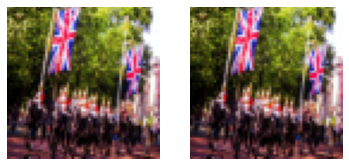

In [ ]:
dls.show_batch()

## Calculate feature loss

In [ ]:
#|export
def gram_matrix(x):
    """function to calculate the gram matrix"""
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
#|export
pixel_loss = F.l1_loss

In [ ]:
#|export
class FeatureLoss(nn.Module):
    """class to calculate feature loss"""
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        """gather the feature maps and store them"""
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        """calculate the feature losses and store in list"""
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [pixel_loss(input,target)]
        self.feat_losses += [pixel_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [pixel_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

Feature loss helps the network to compare the pixels of the target and the input image and check if the two images are the same.

In [ ]:
#|export
def get_ft_model(pretrained=True):
    """prepare a model for feature extraction"""
    from torchvision.models import vgg16
    
    ft_model = vgg16(pretrained=pretrained).features.cuda().eval()
    for p in ft_model.parameters(): p.requires_grad_(False)
    return ft_model

We only need to pass the images through the netowrk once. So, we need to turn off the updates to the network weights. `requires_grad_` is like asking the network "do not train".
We need to extract the features from our input image as well as the target image which we can compare later. To extract the features, we will use a simple pre-trained network like "vgg16". 

In [ ]:
#|export
def calc_ft_loss(pretrained=True):
    """calculate the feature loss using the given architecture"""
    ft_model = get_ft_model(pretrained)
    blocks = [i-1 for i,o in enumerate(ft_model.children()) if isinstance(o,nn.MaxPool2d)]
    return FeatureLoss(ft_model, blocks[2:5], [5,15,2])

The features are grabbed just before the grid size changes and the maxpooling layer in network is where the grid size change occurs. We iterate over the different layers of the network (children) and then grabbing the layer just before the maxpool layer (i-1) as this is where the grid size changes

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()